In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.experimental.optimizers import adam

In [2]:
a = 1
b = 0
beta = 0.98
n = 2**14
k = 1
m = 10
nn_shapes = jnp.array([m, 2*m, m])

In [3]:
@jax.jit
def linear(X, w, b):
    return jnp.dot(X, w) + b


@jax.jit
def relu(X, w, b):
    return jnp.maximum(linear(X, w, b), 0)


@jax.jit
def tanh(X, w, b):
    return jax.nn.tanh(linear(X, w, b))


@jax.jit
def output(X, w, b, min_val, max_val):
    output = jax.nn.sigmoid(linear(X, w, b))
    move = (max_val - min_val) / 2
    return output * move + move


@jax.jit
def V_hat(params, x):
    l1 = tanh(x, params['vw0'], params['vb0'])
    l2 = tanh(l1, params['vw1'], params['vb1'])
    l3 = tanh(l2, params['vw2'], params['vb2'])
    return jnp.squeeze(linear(l3, params['vwf'], params['vbf']))


@jax.jit
def opt_control(params, beta, x):
    l1 = tanh(x, params['cw0'], params['cb0'])
    l2 = tanh(l1, params['cw1'], params['cb1'])
    l3 = tanh(l2, params['cw2'], params['cb2'])
    return jnp.squeeze(output(l3, params['cwf'], params['cbf'], 0, x))


@jax.jit
def future(params, beta, x):
    u = lambda c: jnp.log(c)
    c_star = opt_control(params, beta, x)
    x_prime = x - jnp.sum(c_star)
    return jnp.squeeze(u(c_star) + beta * V_hat(params, x_prime)), (jax.grad(u)(c_star) - jax.grad(V_hat, argnums=(1))(params, x_prime))**2

  
@jax.jit
def epsilon_sq(params, beta, x):
    v = V_hat(params, x)
    f = future(params, beta, x)
    
    return (v - f[0])**2 + f[1]


@jax.jit
def batch_loss(params, beta, X):
    e2 = jnp.mean(jax.vmap(epsilon_sq, in_axes=(None, None, 0))(params, beta, X))
    # f2 = jnp.mean(jax.vmap(future, in_axes=(None, None, 0))(params, beta, X))
    return e2

In [4]:
w00 = jax.random.normal(jax.random.PRNGKey(6), shape=(1, nn_shapes[0]))
w01 = jax.random.normal(jax.random.PRNGKey(7), shape=(nn_shapes[0], nn_shapes[1]))
w02 = jax.random.normal(jax.random.PRNGKey(8), shape=(nn_shapes[1], nn_shapes[2]))
w0f = jax.random.normal(jax.random.PRNGKey(9), shape=(nn_shapes[2], 1))
b00 = jax.random.normal(jax.random.PRNGKey(52), shape=(1, nn_shapes[0]))
b01 = jax.random.normal(jax.random.PRNGKey(51), shape=(1, nn_shapes[1]))
b02 = jax.random.normal(jax.random.PRNGKey(58), shape=(1, nn_shapes[2]))
b0f = jax.random.normal(jax.random.PRNGKey(48), shape=(1, 1))

params0 = {'vw0': w00, 'vw1': w01, 'vw2': w02, 'vwf': w0f, 'vb0': b00, 'vb1': b01, 'vb2': b02, 'vbf':b0f,
           'cw0': w00, 'cw1': w01, 'cw2': w02, 'cwf': w0f, 'cb0': b00, 'cb1': b01, 'cb2': b02, 'cbf':b0f}

In [5]:
def training_loop(opt_update, opt_state, tol=1e-10, max_iter=10**3):
    j = 0
    loss = jnp.inf
    
    while loss > tol and j < max_iter:
        params = get_params(opt_state)
        X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
        
        loss, grad = jax.value_and_grad(batch_loss)(params, beta, X)
        
        opt_state = opt_update(j, grad, opt_state)
        if j % 100 == 0:
            print(f'Iteration: {j}\tLoss: {loss}\n')
        j += 1
        
    return opt_state

In [6]:
opt_init, opt_update, get_params = adam(step_size=0.01)
opt_state = opt_init(params0)
opt_state = training_loop(opt_update, opt_state, max_iter=1000)

Iteration: 0	Loss: 1120.432861328125

Iteration: 100	Loss: 3.7317230701446533

Iteration: 200	Loss: 2.3463823795318604

Iteration: 300	Loss: 1.692105770111084

Iteration: 400	Loss: 1.0339535474777222

Iteration: 500	Loss: 0.8059003949165344

Iteration: 600	Loss: 0.5953522324562073

Iteration: 700	Loss: 0.5936436653137207

Iteration: 800	Loss: 0.6300380229949951

Iteration: 900	Loss: 0.5179781913757324



<AxesSubplot:xlabel='X', ylabel='estimated_v'>

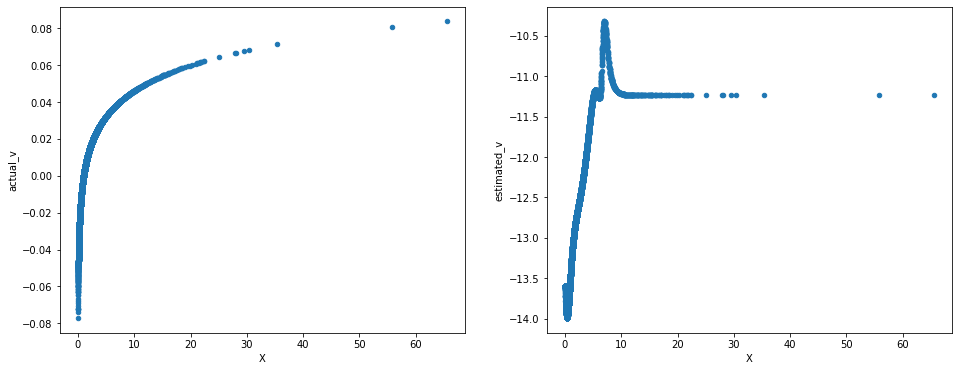

In [7]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])

In [8]:
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, max_iter = 2000)

Iteration: 0	Loss: 0.47262102365493774

Iteration: 100	Loss: 0.9613584876060486

Iteration: 200	Loss: 0.9072470664978027

Iteration: 300	Loss: 0.47680431604385376

Iteration: 400	Loss: 0.34256988763809204

Iteration: 500	Loss: 0.32442909479141235

Iteration: 600	Loss: 0.43410158157348633

Iteration: 700	Loss: 0.3147101402282715

Iteration: 800	Loss: 0.22666358947753906

Iteration: 900	Loss: 0.1981300413608551

Iteration: 1000	Loss: 1.64154052734375

Iteration: 1100	Loss: 0.25378963351249695

Iteration: 1200	Loss: 0.15870782732963562

Iteration: 1300	Loss: 0.16231398284435272

Iteration: 1400	Loss: 0.20349624752998352

Iteration: 1500	Loss: 0.33617764711380005

Iteration: 1600	Loss: 0.2313913255929947

Iteration: 1700	Loss: 0.17553937435150146

Iteration: 1800	Loss: 0.9139561653137207

Iteration: 1900	Loss: 0.12289953231811523



<AxesSubplot:xlabel='X', ylabel='estimated_v'>

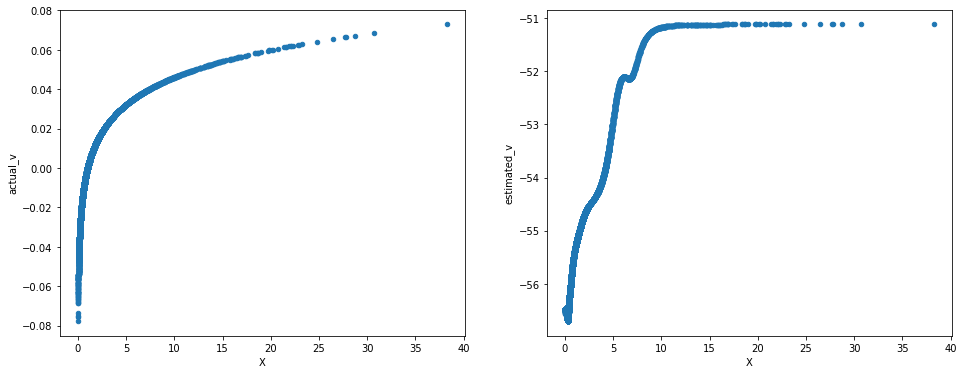

In [9]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])

In [10]:
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, max_iter = 2000)

Iteration: 0	Loss: 1.6063849925994873

Iteration: 100	Loss: 0.7120506763458252

Iteration: 200	Loss: 0.2818329930305481

Iteration: 300	Loss: 0.20813484489917755

Iteration: 400	Loss: 0.16098299622535706

Iteration: 500	Loss: 0.1417922079563141

Iteration: 600	Loss: 0.10252726078033447

Iteration: 700	Loss: 0.09316085278987885

Iteration: 800	Loss: 0.08261028677225113

Iteration: 900	Loss: 0.0628671795129776

Iteration: 1000	Loss: 0.15455995500087738

Iteration: 1100	Loss: 0.11492098867893219

Iteration: 1200	Loss: 0.057177696377038956

Iteration: 1300	Loss: 0.061175525188446045

Iteration: 1400	Loss: 0.05481116473674774

Iteration: 1500	Loss: 0.07609843462705612

Iteration: 1600	Loss: 0.04357651621103287

Iteration: 1700	Loss: 0.039780765771865845

Iteration: 1800	Loss: 0.19852864742279053

Iteration: 1900	Loss: 0.03581031784415245



<AxesSubplot:xlabel='X', ylabel='estimated_v'>

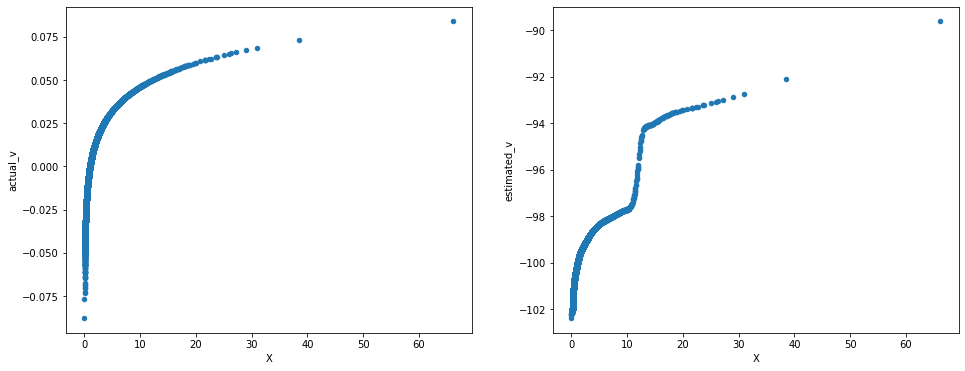

In [11]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])

In [12]:
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, max_iter = 2000)

Iteration: 0	Loss: 0.03258960321545601

Iteration: 100	Loss: 0.08383779972791672

Iteration: 200	Loss: 0.16770562529563904

Iteration: 300	Loss: 0.052202947437763214

Iteration: 400	Loss: 0.06453435122966766

Iteration: 500	Loss: 0.0836067870259285

Iteration: 600	Loss: 0.16999265551567078

Iteration: 700	Loss: 0.7864675521850586

Iteration: 800	Loss: 0.22831860184669495

Iteration: 900	Loss: 0.19941535592079163

Iteration: 1000	Loss: 0.11369992047548294

Iteration: 1100	Loss: 0.12293203920125961

Iteration: 1200	Loss: 1.282487154006958

Iteration: 1300	Loss: 0.267909437417984

Iteration: 1400	Loss: 0.13939431309700012

Iteration: 1500	Loss: 0.07543408870697021

Iteration: 1600	Loss: 0.05059788003563881

Iteration: 1700	Loss: 0.061057962477207184

Iteration: 1800	Loss: 0.06964084506034851

Iteration: 1900	Loss: 0.031363509595394135



<AxesSubplot:xlabel='X', ylabel='estimated_v'>

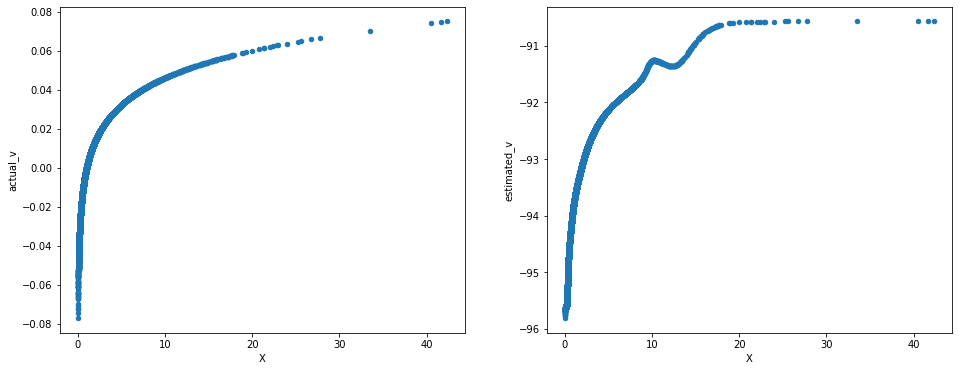

In [13]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])

In [14]:
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, max_iter = 5000)

Iteration: 0	Loss: 0.03403453528881073

Iteration: 100	Loss: 0.06758250296115875

Iteration: 200	Loss: 0.10057917982339859

Iteration: 300	Loss: 0.08908604085445404

Iteration: 400	Loss: 0.04056765139102936

Iteration: 500	Loss: 0.03734118863940239

Iteration: 600	Loss: 0.034492865204811096

Iteration: 700	Loss: 0.030683785676956177

Iteration: 800	Loss: 0.03995654731988907

Iteration: 900	Loss: 0.018979625776410103

Iteration: 1000	Loss: 0.022882381454110146

Iteration: 1100	Loss: 0.016464393585920334

Iteration: 1200	Loss: 0.02071227878332138

Iteration: 1300	Loss: 0.015150636434555054

Iteration: 1400	Loss: 0.03993479162454605

Iteration: 1500	Loss: 0.05796993523836136

Iteration: 1600	Loss: 0.012616516090929508

Iteration: 1700	Loss: 0.03737881779670715

Iteration: 1800	Loss: 0.026369400322437286

Iteration: 1900	Loss: 0.020301591604948044

Iteration: 2000	Loss: 0.015852689743041992

Iteration: 2100	Loss: 0.031400300562381744

Iteration: 2200	Loss: 0.04162353277206421

Iteration: 2

<AxesSubplot:xlabel='X', ylabel='estimated_v'>

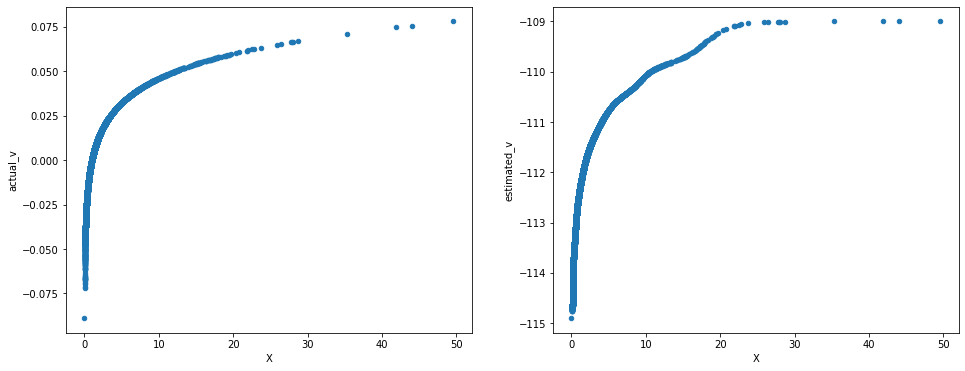

In [15]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])

In [16]:
opt_state = opt_init(params)
opt_state = training_loop(opt_update, opt_state, max_iter = 5000)

Iteration: 0	Loss: 0.012659522704780102

Iteration: 100	Loss: 0.015245789662003517

Iteration: 200	Loss: 0.015313845127820969

Iteration: 300	Loss: 0.014058385044336319

Iteration: 400	Loss: 0.049452219158411026

Iteration: 500	Loss: 0.015958692878484726

Iteration: 600	Loss: 0.022175142541527748

Iteration: 700	Loss: 0.032887667417526245

Iteration: 800	Loss: 0.01759142428636551

Iteration: 900	Loss: 0.015372825786471367

Iteration: 1000	Loss: 0.04951736330986023

Iteration: 1100	Loss: 0.011151761747896671

Iteration: 1200	Loss: 0.016833588480949402

Iteration: 1300	Loss: 0.010111513547599316

Iteration: 1400	Loss: 0.41242098808288574

Iteration: 1500	Loss: 0.16552585363388062

Iteration: 1600	Loss: 0.08712005615234375

Iteration: 1700	Loss: 0.02823295071721077

Iteration: 1800	Loss: 0.030348017811775208

Iteration: 1900	Loss: 0.02391229197382927

Iteration: 2000	Loss: 0.02282063290476799

Iteration: 2100	Loss: 0.021261008456349373

Iteration: 2200	Loss: 0.03139621019363403

Iteration

<AxesSubplot:xlabel='X', ylabel='estimated_v'>

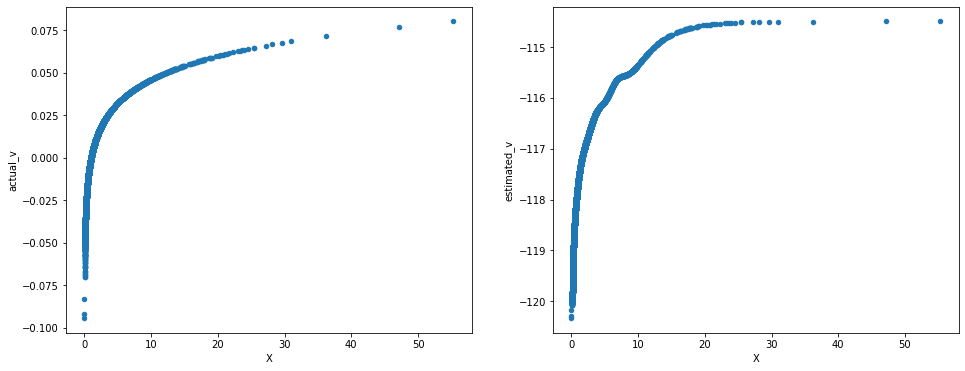

In [17]:
params = get_params(opt_state)

X = jnp.exp(a * jax.random.normal(jax.random.PRNGKey(np.random.randint(1, int(1e8))), shape=(n,))) + b
y = (1 - beta) * jnp.log(X)
y_hat = jax.vmap(V_hat, in_axes=(None, 0))(params, X)

df = pd.DataFrame(jnp.concatenate((X.reshape(-1, 1), y.reshape(-1, 1), y_hat.reshape(-1, 1)), axis=1))
df.columns = ['X', 'actual_v', 'estimated_v']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
df.plot(x='X', y='actual_v', kind='scatter', ax=axes[0])
df.plot(x='X', y='estimated_v', kind='scatter', ax=axes[1])